# Description

This notebook calculates the Poisson credibility (credence) for the hypothesis that the event occurence rate is smaller or equal to ```r_hypothesis```, given the number of observed events ```n_events``` during a ```test_duration```, using a uniform prior distribution.

This notebook tells you how much belief you can put into the idea that your event occurence rate is at most ```r_hypothesis``` after having done a test of duration ```test_duration``` during which you observed ```n_events``` events. This result depends on a so-called prior distribution that models your belief in different possible event occurence rates before the test. By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the event occurence rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [1]:
test_duration = 10
n_events = 2
r_hypothesis = 0.5

round_to_digits = 4

assert isinstance(test_duration, (int, float)) and test_duration > 0
assert isinstance(n_events, int) and n_events >= 0
assert isinstance(r_hypothesis, float) and r_hypothesis >= 0
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

You have observed 2 events during a test of duration 10
The credibility of the hypothesis is 0.8753 that the event occurence rate is at most 0.5


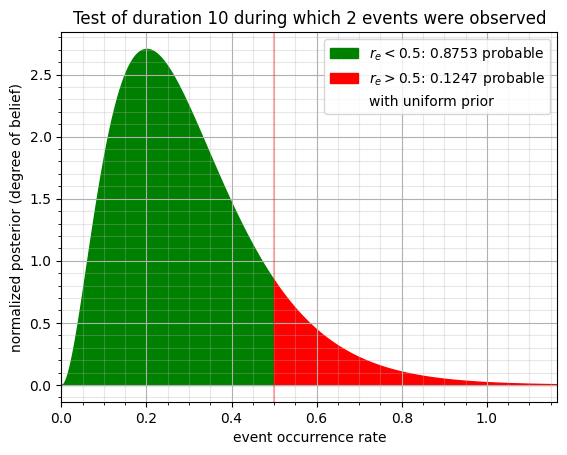

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

#posterior is unnormalized to save calculation time, remember to normalize result when needed
def posterior_prob_poisson_r(r_event, test_duration, n_events, prior):
    return mp.power(mp.mpf(r_event*test_duration), n_events) / mp.fac(n_events) * mp.exp(-r_event*test_duration) * prior(r_event, test_duration)

posterior_prob_poisson_r_vectorized = np.vectorize(posterior_prob_poisson_r)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large test_duration
def integrate_posterior_prob_poisson_r(test_duration, n_events, prior, bounds):
    mean = (n_events+1) / test_duration
    std_dev = (n_events+1)**0.5 / test_duration
    prescale = 1/posterior_prob_poisson_r(mean, test_duration, n_events, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean+3*std_dev, bounds[0]), bounds[1], args=(test_duration, n_events, prior_prescaled))[0]
        
    return norm / prescale

r_plotmax = max(r_hypothesis*1.2, (n_events+1)/test_duration + 5*(n_events+1)**0.5/test_duration) #mean+5*std_dev
r = np.linspace(0, r_plotmax, 1001)

prior = lambda rate, duration: 1
norm = integrate_posterior_prob_poisson_r(test_duration, n_events, prior, [0, np.inf])
posterior_probs = posterior_prob_poisson_r_vectorized(r, test_duration, n_events, prior) / norm

hypothesis_credibility = integrate_posterior_prob_poisson_r(test_duration, n_events, prior, [0, r_hypothesis]) / norm
hypothesis_credibility_rounded = mp.nstr(hypothesis_credibility, round_to_digits)
null_hypothesis_credibility_rounded = mp.nstr(1-hypothesis_credibility, round_to_digits)
print('You have observed {} events during a test of duration {}'.format(n_events, test_duration))
print('The credibility of the hypothesis is {} that the event occurence rate is at most {}'.format(hypothesis_credibility_rounded, r_hypothesis))

plt.fill_between(r[r<r_hypothesis], posterior_probs.astype(float)[r<r_hypothesis], color='green', label='$r_e < {}$: {} probable'.format(r_hypothesis, hypothesis_credibility_rounded))
plt.fill_between(r[r>=r_hypothesis], posterior_probs.astype(float)[r>=r_hypothesis], color='red', label='$r_e > {}$: {} probable'.format(r_hypothesis, null_hypothesis_credibility_rounded))
plt.plot(r, posterior_probs, color='black', alpha=0, label='with uniform prior')
plt.axvline(r_hypothesis, 0, 1, color='red', alpha=0.3)

plt.gca().set_title('Test of duration {} during which {} events were observed'.format(test_duration, n_events))
plt.gca().set_xlabel('event occurrence rate')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend(loc='upper right')

plt.gca().set_xlim([0, r_plotmax]); #change plot range here